# ViT

## First approach: Fine Tuning

We will fine-tune the google pre-trained ViT to adjust weights of the model to our task.

Here is a reminder of the ViT architecture

![ViT](images/ViT.png)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from methods import BasicCNN
from utils import WildfireDataset
from utils import split_val_dataset

In [2]:
device = torch.device('mps') # MacOS
# variables #
batchsize = 10
data_folder = Path("./data/valid")

In [3]:
# Data loading
train, test = split_val_dataset(data_folder)

transform = v2.Compose([
    v2.ToImage(), # Convert into Image tensor
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = WildfireDataset(train, transform)
test_dataset = WildfireDataset(test, transform)

trainloader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    num_workers=4
)

testloader = DataLoader(
    test_dataset,
    batch_size=batchsize,
    shuffle=False,
    num_workers=4
)

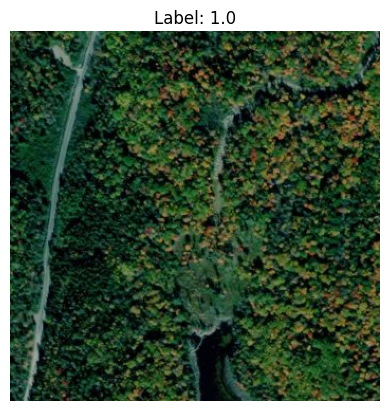

In [4]:
train_dataset.__showitem__(1)